# **8.The Baseline Modelling**

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import email
import seaborn as sns
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [35]:
import joblib
df = joblib.load('/content/drive/MyDrive/case study 2/final_40k.pkl')

In [36]:
df.shape

(41474, 2)

In [38]:
df.head()

,mail,len
0,here our forecast,17
1,traveling have business meeting takes the fun ...,534
2,test successful way,19
3,randy can you send schedule the salary and lev...,132
4,let shoot for tuesday,21


In [39]:
from sklearn.model_selection import train_test_split
train , test = train_test_split(df.mail, test_size=0.30, random_state=42)

In [40]:
x = []
y = []
for i in tqdm(train):
  a = i.split()
  for j in range(1,len(a)):
        x.append(' '.join(a[:j]))
        y.append(' '.join(a[j:]))

100%|██████████| 29031/29031 [00:01<00:00, 22693.37it/s]


In [41]:
train_set = pd.DataFrame(data={'x_train':x,'y_train':y})
train_set['x_train'] = '<start> ' + train_set['x_train'] + ' <end>'
train_set['y_train'] = '<start> ' + train_set['y_train'] + ' <end>'
train_set.head()

,x_train,y_train
0,<start> can <end>,<start> everyone meet today please let know da...
1,<start> can everyone <end>,<start> meet today please let know daren <end>
2,<start> can everyone meet <end>,<start> today please let know daren <end>
3,<start> can everyone meet today <end>,<start> please let know daren <end>
4,<start> can everyone meet today please <end>,<start> let know daren <end>


In [48]:
train_set['x_train_len'] = train_set['x_train'].apply(lambda text:len(text.split()))

#here we remove all the rows from x_train / x_test where len is less then 10 and more then 20
train_set = train_set[train_set['x_train_len']>10]
train_set = train_set[train_set['x_train_len']<20]

In [42]:
x_test = []
y_test = []
for i in tqdm(test):
  a = i.split()
  for j in range(1,len(a)):
        x_test.append(' '.join(a[:j]))
        y_test.append(' '.join(a[j:]))

100%|██████████| 12443/12443 [00:00<00:00, 18345.84it/s]


In [43]:
test_set = pd.DataFrame(data={'x_test':x_test,'y_test':y_test})
test_set['x_test'] = '<start> ' + test_set['x_test'] + ' <end>'
test_set['y_test'] = '<start> ' + test_set['y_test'] + ' <end>'
test_set.head()

,x_test,y_test
0,<start> derek <end>,<start> can you forward the <end>
1,<start> derek can <end>,<start> you forward the <end>
2,<start> derek can you <end>,<start> forward the <end>
3,<start> derek can you forward <end>,<start> the <end>
4,<start> begin <end>,<start> get the actual presentations set anyon...


In [71]:
test_set['x_test_len'] = test_set['x_test'].apply(lambda text:len(text.split()))

#here we remove all the rows from x_train / x_test where len is less then 10 and more then 20
test_set = test_set[test_set['x_test_len']>10]
test_set = test_set[test_set['x_test_len']<20]
test_set.shape

(64032, 3)

In [72]:
tk = Tokenizer()#filters: If not provided, by default filters out all punctuation terms
tk_text = tk.fit_on_texts(list(train_set.x_train))
vocab = len(tk.word_index) + 1
print('the vocab size is', vocab)

the vocab size is 8785


In [73]:
#now we convert train and text datainto a corresponding index
train_seq = tk.texts_to_sequences(list(train_set.x_train))
print('the length of the train seq' ,len(train_seq[0]))
#took padding length as 9000 because in each data points has avg 30 words sentence.
train_data = pad_sequences(train_seq ,padding="post", maxlen=30)

test_seq = tk.texts_to_sequences(list(test_set.x_test))
print('the length of test seq',len(test_seq[0]))
test_data = pad_sequences(test_seq, padding="post",maxlen=30)

the length of the train seq 11
the length of test seq 11


In [74]:
tk_y = Tokenizer()#filters: If not provided, by default filters out all punctuation terms
tk_text_y = tk_y.fit_on_texts(list(train_set.y_train))
vocab_y = len(tk_y.word_index) + 1
print('the vocab size is', vocab_y)

the vocab size is 9549


In [75]:
#now we convert train and text datainto a corresponding index
train_seq_y = tk_y.texts_to_sequences(list(train_set.y_train))
print('the length of the train seq' ,len(train_seq_y[0]))
#took padding length as 9000 because in each data points has avg 30 words sentence.
train_data_y = pad_sequences(train_seq_y ,padding="post", maxlen=30)

test_seq_y = tk_y.texts_to_sequences(list(test_set.y_test))
print('the length of test seq',len(test_seq_y[0]))
test_data_y = pad_sequences(test_seq_y, padding="post",maxlen=30)

the length of the train seq 3
the length of test seq 38


In [77]:
#the very very basic LSTM model with the some hidden layes
tf.keras.backend.clear_session()
input_lay = tf.keras.Input(shape=(30,))

emd_layer = tf.keras.layers.Embedding(vocab, 300, input_length=30)(input_lay)
dense1 = tf.keras.layers.LSTM(300,return_sequences=True)(emd_layer)

dropout_lay1 = tf.keras.layers.Dropout(rate = 0.3 , name = 'dropout_lay1')(dense1)

dense2 = tf.keras.layers.Dense(512,activation='relu', kernel_initializer=tf.keras.initializers.he_normal, name = 'dense2')(dropout_lay1)

dropout_lay2 = tf.keras.layers.Dropout(rate = 0.3 , name = 'dropout_lay2')(dense2)

dense3 = tf.keras.layers.Dense(512,activation='relu', kernel_initializer=tf.keras.initializers.he_normal ,name = 'dense3')(dropout_lay2)

output = tf.keras.layers.Dense(vocab_y,activation='softmax',kernel_initializer=tf.keras.initializers.he_normal , name = 'output')(dense3)

model = tf.keras.Model(inputs= input_lay, outputs=output)

In [78]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           2635500   
                                                                 
 lstm (LSTM)                 (None, 30, 300)           721200    
                                                                 
 dropout_lay1 (Dropout)      (None, 30, 300)           0         
                                                                 
 dense2 (Dense)              (None, 30, 512)           154112    
                                                                 
 dropout_lay2 (Dropout)      (None, 30, 512)           0         
                                                                 
 dense3 (Dense)              (None, 30, 512)           262656

In [79]:
optimizer=tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [80]:
his = model.fit(train_data, train_data_y, epochs=10, validation_data=(test_data,test_data_y) , batch_size=512)

Epoch 1/10
295/295 [==============================] - 78s 257ms/step - loss: 4.4287 - accuracy: 0.4287 - val_loss: 4.2585 - val_accuracy: 0.4386
Epoch 2/10
295/295 [==============================] - 75s 254ms/step - loss: 4.0479 - accuracy: 0.4372 - val_loss: 4.3853 - val_accuracy: 0.4335
Epoch 3/10
295/295 [==============================] - 75s 253ms/step - loss: 3.8762 - accuracy: 0.4414 - val_loss: 4.5974 - val_accuracy: 0.4108
Epoch 4/10
295/295 [==============================] - 75s 254ms/step - loss: 3.7059 - accuracy: 0.4478 - val_loss: 4.9647 - val_accuracy: 0.4038
Epoch 5/10
295/295 [==============================] - 75s 254ms/step - loss: 3.5424 - accuracy: 0.4542 - val_loss: 5.3767 - val_accuracy: 0.3863
Epoch 6/10
295/295 [==============================] - 75s 254ms/step - loss: 3.3925 - accuracy: 0.4603 - val_loss: 5.5857 - val_accuracy: 0.3733
Epoch 7/10
295/295 [==============================] - 75s 253ms/step - loss: 3.2563 - accuracy: 0.4658 - val_loss: 5.7213 - val_ac

In [81]:
h = his.history
loss = h['loss']
val_loss = h['val_loss']

Text(0.5, 1.0, 'Loss Vs No of epochs')

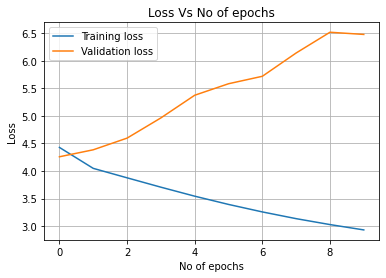

In [82]:
plt.plot(loss,label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.grid()
plt.xlabel('No of epochs')
plt.ylabel('Loss')
plt.title('Loss Vs No of epochs')

Text(0.5, 1.0, 'accuracy Vs No of epochs')

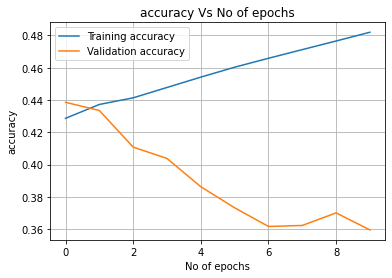

In [83]:
accuracy = h['accuracy']
val_accuracy = h['val_accuracy']
plt.plot(accuracy,label='Training accuracy')
plt.plot(val_accuracy, label='Validation accuracy')
plt.legend()
plt.grid()
plt.xlabel('No of epochs')
plt.ylabel('accuracy')
plt.title('accuracy Vs No of epochs')

In [101]:
eng_word = tk_y.word_index
new_dict = dict([(value, key) for key, value in eng_word.items()])

In [102]:
import numpy as np
def predict(train):
  a = model.predict(train.reshape(-1,30))
  f = []
  d = []
  for i in a[0]:
    #print(i)
    f.append(np.argmax(i))
  for  i in f:
    if i != 0:
      d.append(new_dict[i])

  return(' '.join(d))

In [103]:
predict(train_data[185])

'start responded normally the the the enron attorney attorney mexico internal internal internal internal signed appointed appointed appointed tax into into this this this add your your thanks regards end'

In [104]:
data_sam = train_set.sample(15000)
import nltk.translate.bleu_score as bleu
bleu_score = []
for i in tqdm(range(15000)):
  actual  = data_sam.y_train.values[i]
  input = tk.texts_to_sequences([str(data_sam.x_train.values[i])])
  input = pad_sequences(input, padding="post",maxlen= 30)
  Predict = predict(input)
  bleu_score.append(bleu.sentence_bleu([actual.split(),], Predict.split()))
print()
print('Bleu Score ==> ', np.mean(bleu_score))

  0%|          | 0/15000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  0%|          | 3/15000 [00:00<10:58, 22.79it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  0%|          | 9/15000 [00:00<11:28, 21.77it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
100%|██████████| 15000/15000 [11:30<00:00, 21.73it/s]


Bleu Score ==>  0.2063198597853522


**The Bleu score is 0.20 and improves the bleu score we use the encoder and decoder-based model.**

# 9 Encoder Decoder Model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import email
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
import joblib
df = joblib.load('clean.pkl')

In [ ]:
#df = df.sample(15000)
df.head()

,clean
0,here is our forecast
1,traveling to have a business meeting takes the...
2,plus your thoughts on any changes that need to...
3,follow these steps so you do not misplace thes...
4,i have been involved in most of the meetings a...


In [ ]:
x = []
y = []
for i in tqdm(df.clean):
  a = i.split()
  for j in range(1,len(a)):
        x.append(' '.join(a[:j]))
        y.append(' '.join(a[j:]))

100%|██████████| 79616/79616 [00:07<00:00, 11034.37it/s]


In [ ]:
train_set = pd.DataFrame(data={'x_train':x,'y_train':y})
# train_set['x_train'] = '<start> ' + train_set['x_train'] + ' <end>'
# train_set['y_train'] = '<start> ' + train_set['y_train'] + ' <end>'
train_set.head()

,x_train,y_train
0,here,is our forecast
1,here is,our forecast
2,here is our,forecast
3,traveling,to have a business meeting takes the fun out o...
4,traveling to,have a business meeting takes the fun out of t...


In [ ]:
train_set.shape

(2180436, 2)

In [ ]:
train_set['x_train_len'] = train_set['x_train'].apply(lambda text:len(text.split()))
train_set['y_train_len'] = train_set['y_train'].apply(lambda text:len(text.split()))

#here we remove all the rows from x_train / x_test where len is less then 5


In [ ]:
train_set.head()

,x_train,y_train,x_train_len,y_train_len
0,here,is our forecast,1,3
1,here is,our forecast,2,2
2,here is our,forecast,3,1
3,traveling,to have a business meeting takes the fun out o...,1,101
4,traveling to,have a business meeting takes the fun out of t...,2,100


In [ ]:
train_set = train_set[train_set['x_train_len']>3]
train_set = train_set[train_set['x_train_len']<30]

train_set = train_set[train_set['y_train_len']<8]

train_set.shape

(344472, 4)

In [ ]:
max(train_set.x_train_len.values)

29

In [ ]:
max(train_set.y_train_len.values)

7

In [ ]:
data = train_set

In [ ]:


data['enc_inp'] = '<start> ' + data['x_train'].astype(str)  + ' <end>'

data['dec_inp'] = '<start> ' + data['y_train'].astype(str)
data['our'] = data['y_train'].astype(str) + ' <end>'

data = data.drop(['x_train','y_train','x_train_len', 'y_train_len'], axis=1)
# only for the first sentance add a toke <end> so that we will have <end> in tokenizer
data.head()

,enc_inp,dec_inp,our
107,<start> plus your thoughts on <end>,<start> any changes that need to be made,any changes that need to be made <end>
108,<start> plus your thoughts on any <end>,<start> changes that need to be made,changes that need to be made <end>
109,<start> plus your thoughts on any changes <end>,<start> that need to be made,that need to be made <end>
110,<start> plus your thoughts on any changes that...,<start> need to be made,need to be made <end>
111,<start> plus your thoughts on any changes that...,<start> to be made,to be made <end>


In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.33)

In [ ]:
print('The shape of the train data ==>', train.shape)
print('The shape of the test  data ==>', test.shape)

The shape of the train data ==> (230796, 3)
The shape of the test  data ==> (113676, 3)


In [ ]:
#Train dataset
x_train_encoder = train.enc_inp.values
x_train_decoder = train.dec_inp.values
y_train         = train.our.values

In [ ]:
#test dataset
x_test_encoder = test.enc_inp.values
x_test_decoder = test.dec_inp.values
y_test         = test.our.values

In [ ]:
print('y_train shape and y_test shape ==>' , y_train.shape, y_test.shape)

y_train shape and y_test shape ==> (230796,) (113676,)


In [ ]:
def padding(train , test):
  tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
  tokenizer.fit_on_texts(train)

  x_train =  tokenizer.texts_to_sequences(train)
  x_test  =  tokenizer.texts_to_sequences(test)


  # padding train and test data using the maximum length
  x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, padding='post')
  x_test  = tf.keras.preprocessing.sequence.pad_sequences(x_test,  padding='post')

  return tokenizer , x_train , x_test

In [ ]:
ita_token , x_train_enc , x_test_enc = padding(x_train_encoder , x_test_encoder)
eng_token , x_train_dec , x_test_dec = padding(x_train_decoder , x_test_decoder)
y_token   , y_train     , y_test     = padding(y_train , y_test)

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):

        #Initialize Embedding layer
        #Intialize Encoder LSTM layer
        super().__init__()
        self.inp_vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.input_length = input_length
        self.lstm_size= lstm_size
        self.embedding = tf.keras.layers.Embedding(input_dim=self.inp_vocab_size, output_dim=self.embedding_size, name="embedding_layer_encoder")
        self.lstm = tf.keras.layers.LSTM(self.lstm_size, return_state=True, return_sequences=True, name="Encoder_LSTM", recurrent_initializer='glorot_uniform')

    def call(self,input_sequence,initial_state):
      '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- All encoder_outputs, last time steps hidden and cell state
      '''
      input_embedd = self.embedding(input_sequence)
      lstm_output, lstm_state_h, lstm_state_c = self.lstm(input_embedd,initial_state = initial_state)
      return lstm_output, lstm_state_h, lstm_state_c
    
    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state shape is [32,lstm_units], cell state shape is [32,lstm_units]
      '''
      return tf.zeros((batch_size, self.lstm_size)) , tf.zeros((batch_size, self.lstm_size))

In [ ]:
class Decoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):
      super().__init__()
      self.out_vocab_size = out_vocab_size
      self.embedding_size = embedding_size
      self.input_length = input_length
      self.lstm_size= lstm_size

        #Initialize Embedding layer
        #Intialize Decoder LSTM layer

      self.embedding = tf.keras.layers.Embedding(input_dim = self.out_vocab_size, output_dim = self.embedding_size, name="embedding_decoder_layer")
      
      self.lstm = tf.keras.layers.LSTM(self.lstm_size, return_state=True, return_sequences=True, name="Decoder_lstm_layer", recurrent_initializer='glorot_uniform')
        


    def call(self,input_sequence,initial_states):


      
      input_embedd = self.embedding(input_sequence)
      decoder_output, decoder_final_state_h, decoder_final_state_c = self.lstm(input_embedd,initial_state = initial_states)
      return decoder_output, decoder_final_state_h, decoder_final_state_c

In [ ]:
class Encoder_decoder(tf.keras.Model):
    
    def __init__(self,encoder_inputs_length,decoder_inputs_length, output_vocab_size):
        super().__init__() # https://stackoverflow.com/a/27134600/4084039
        #(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        self.encoder = Encoder(inp_vocab_size = input_vocab, embedding_size =  256, lstm_size = 200, input_length= encoder_inputs_length)
        self.decoder = Decoder(out_vocab_size = output_vocab, embedding_size = 256, lstm_size = 200, input_length= decoder_inputs_length)
        self.dense   = Dense(output_vocab_size, activation='softmax')
        
        #Create encoder object
        #Create decoder object
        #Intialize Dense layer(out_vocab_size) with activation='softmax'
    
    
    def call(self,data):
        '''
        A. Pass the input sequence to Encoder layer -- Return encoder_output,encoder_final_state_h,encoder_final_state_c
        B. Pass the target sequence to Decoder layer with intial states as encoder_final_state_h,encoder_final_state_C
        C. Pass the decoder_outputs into Dense layer 
        
        Return decoder_outputs
        '''
        input_to_encoder,input_to_decoder = data[0], data[1]
        initial_state= self.encoder.initialize_states(tf.shape(input_to_encoder)[0])
        encoder_output,state_h,state_c = self.encoder(input_to_encoder,initial_state)

        decoder_output, decoder_final_state_h, decoder_final_state_c = self.decoder(input_to_decoder, [state_h,state_c]) 
        decoder_output = self.dense(decoder_output)

        # return the decoder output
        return decoder_output

In [ ]:
input_vocab  = len(ita_token.word_index) + 1
output_vocab = len(y_token.word_index) + 1
print('input vocab size ==>' , input_vocab)
print('output vocab size ==>' , output_vocab)

input vocab size ==> 18547
output vocab size ==> 12127


In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation , add
model  = Encoder_decoder(encoder_inputs_length=31 ,decoder_inputs_length=8 , output_vocab_size = output_vocab)


# loss_object = loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
optimizer = tf.keras.optimizers.Adam()
#defining callbacks
his = tf.keras.callbacks.History()
callbacks = [tf.keras.callbacks.TensorBoard(log_dir='logs/model2') , his]
#compiling the model

model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')

model.fit([x_train_enc , x_train_dec], y_train, batch_size=512,epochs = 60, validation_data = ([x_test_enc,x_test_dec], y_test) , callbacks = callbacks)

Epoch 1/60
451/451 [==============================] - 75s 141ms/step - loss: 3.5180 - val_loss: 3.0174
Epoch 2/60
451/451 [==============================] - 62s 137ms/step - loss: 2.8903 - val_loss: 2.7697
Epoch 3/60
451/451 [==============================] - 63s 139ms/step - loss: 2.6992 - val_loss: 2.6467
Epoch 4/60
451/451 [==============================] - 62s 136ms/step - loss: 2.5798 - val_loss: 2.5383
Epoch 5/60
451/451 [==============================] - 63s 139ms/step - loss: 2.4694 - val_loss: 2.4535
Epoch 6/60
451/451 [==============================] - 63s 139ms/step - loss: 2.3706 - val_loss: 2.3603
Epoch 7/60
451/451 [==============================] - 62s 137ms/step - loss: 2.2696 - val_loss: 2.2757
Epoch 8/60
451/451 [==============================] - 63s 139ms/step - loss: 2.1723 - val_loss: 2.1918
Epoch 9/60
451/451 [==============================] - 61s 136ms/step - loss: 2.0722 - val_loss: 2.1096
Epoch 10/60
451/451 [==============================] - 63s 139ms/step - l

In [ ]:
model.summary()

Model: "encoder_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  5113632   
                                                                 
 decoder (Decoder)           multiple                  3470112   
                                                                 
 dense (Dense)               multiple                  2437527   
                                                                 
Total params: 11,021,271
Trainable params: 11,021,271
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Loss Vs No of epochs')

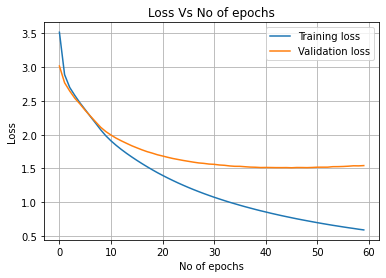

In [ ]:
loss = his.history['loss']
val_loss = his.history['val_loss']
plt.plot(loss,label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.grid()
plt.xlabel('No of epochs')
plt.ylabel('Loss')
plt.title('Loss Vs No of epochs')

In [ ]:
# model.save_weights('/content/drive/MyDrive/model1/best_model1.h5')

In [ ]:
#here we change the key value pair to value key pair
eng_word = y_token.word_index
new_dict = dict([(value, key) for key, value in eng_word.items()])
new_dict[0] = ''

In [ ]:
def predict(input_sentence):
# A. Given input sentence, convert the sentence into integers using tokenizer used earlier
#here we also check the we have the start and end token in sentences
#then we convert out input into to token and do a padding
  input = input_sentence
  if input.split(' ')[0] != '<start>' and input.split(' ')[-1] != '<end>':
    input = '<start>'+ ' ' + input + ' ' + '<end>'
  else:
    input = str(input)
  input = ita_token.texts_to_sequences([str(input)])
  input = pad_sequences(input, padding="post",maxlen= 20)

#as we know we have a three layer 1 ==> encoder 2 ==> decoder 3 ==> dense
#so first is encoder we give the input as input sec and ini_state

  enc_ini_states = model.layers[0].initialize_states(1)
  enc_out, enc_h_state, enc_c_state = model.layers[0](input, enc_ini_states)

#output of the encoder is a input as decoder
# first word input of decoder is start token 
# then 2nd input of decoder is predecting word by model

  decoder_initial_state = [enc_h_state, enc_c_state]
  decoder_initial_input = np.zeros((1,1))
  decoder_initial_input[0,0] = eng_token.word_index['<start>']

  predict_word = []
  w = []
  for i in range(20):
    dec_out, dec_h_state, dec_c_state = model.layers[1](decoder_initial_input, decoder_initial_state)
    # we use 3rd layer and we get the max proba word as out put and the this word is next input of the decoder 
    english_predict = np.argmax(model.layers[2](dec_out).numpy().ravel())
    predict_word.append(english_predict)
    decoder_initial_input[0,0] = english_predict
    #replacing the next decoder initial states with current decoder output 
    decoder_initial_state = [dec_h_state, dec_c_state]
    w.append(new_dict[english_predict])

    if new_dict[english_predict] == '<end>':
      break
  return ' '.join(w)

In [ ]:
predict('<start> you have any <end>')

'questions please let me know your thoughts <end>'

In [ ]:
predict('<start> my mood is not good if <end>')

'there is a problem <end>'

In [ ]:
predict('<start> if you have any   <end>')

'questions please feel free to call <end>'

In [ ]:
predict('<start> how are you and <end>')

'save her for your review <end>'

In [ ]:
data_sam = data.sample(20)
for i in range(20):
  print('Input  ==>' , data_sam.enc_inp.values[i])
  print('Output ==>' , data_sam.dec_inp.values[i])
  print('Predict ==>', predict(data_sam.enc_inp.values[i]))
  print(50 * '==')

Input  ==> <start> the meter cards will use the calculation only gary if we need to clarify any of the above <end>
Output ==> <start> please let me know
Predict ==> procedures please let me know <end>
Input  ==> <start> click here to see what we have to offer he is expected to play this week he is still expected to play he <end>
Output ==> <start> is expected to start this week
Predict ==> will take more later <end>
Input  ==> <start> please update me on your <end>
Output ==> <start> progress
Predict ==> cell phone if you need <end>
Input  ==> <start> i have added some language to your proposals but have kept the intention intact please take a look at the attached and let me know <end>
Output ==> <start> if anything further
Predict ==> when you would like to proceed <end>
Input  ==> <start> we have completed some studies but still need to check on a case or two hope to have a breif system impact study report out to you very <end>
Output ==> <start> soon
Predict ==> soon <end>
Input  ==

In [ ]:
from tqdm import tqdm
data_sam = data.sample(10000)
import nltk.translate.bleu_score as bleu
bleu_score = []
for i in tqdm(range(1000)):
  actual  = data_sam.our.iloc[i] 
  Predict = predict(data_sam.enc_inp.iloc[i])
  bleu_score.append(bleu.sentence_bleu([actual.split(),], Predict.split()))
print('Bleu Score ==> ', np.mean(bleu_score))

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  2%|▏         | 15/1000 [00:00<00:39, 24.80it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
100%|██████████| 1000/1000 [00:32<00:00, 30.65it/s]

Bleu Score ==>  0.7159375178311874


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save_weights('/content/drive/MyDrive/model_new/best_model1.h5')

# 10 Encoder Decoder Model with Attention

In [ ]:
#load the data 
import joblib
data = joblib.load('/content/drive/MyDrive/case study 2/enc_dec.pkl')

In [ ]:
#df = df.head(15000)
data.head()

,enc_inp,dec_inp,our
107,<start> plus your thoughts on <end>,<start> any changes that need to be made,any changes that need to be made <end>
108,<start> plus your thoughts on any <end>,<start> changes that need to be made,changes that need to be made <end>
109,<start> plus your thoughts on any changes <end>,<start> that need to be made,that need to be made <end>
110,<start> plus your thoughts on any changes that...,<start> need to be made,need to be made <end>
111,<start> plus your thoughts on any changes that...,<start> to be made,to be made <end>


In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.33)

In [ ]:
print('The shape of the train data ==>', train.shape)
print('The shape of the test  data ==>', test.shape)

The shape of the train data ==> (230796, 3)
The shape of the test  data ==> (113676, 3)


In [ ]:
230796//512

450

In [ ]:
113676//512

222

In [ ]:
#Train dataset
x_train_encoder = train.enc_inp.values
x_train_decoder = train.dec_inp.values
y_train         = train.our.values

In [ ]:
#test dataset
x_test_encoder = test.enc_inp.values
x_test_decoder = test.dec_inp.values
y_test         = test.our.values

In [ ]:
print('y_train shape and y_test shape ==>' , y_train.shape, y_test.shape)

y_train shape and y_test shape ==> (230796,) (113676,)


In [ ]:
def padding(train , test):
  tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
  tokenizer.fit_on_texts(train)

  x_train =  tokenizer.texts_to_sequences(train)
  x_test  =  tokenizer.texts_to_sequences(test)


  # padding train and test data using the maximum length
  x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, padding='post')
  x_test  = tf.keras.preprocessing.sequence.pad_sequences(x_test,  padding='post')

  return tokenizer , x_train , x_test

In [ ]:
ita_token , x_train_enc , x_test_enc = padding(x_train_encoder , x_test_encoder)
eng_token , x_train_dec , x_test_dec = padding(x_train_decoder , x_test_decoder)
y_token   , y_train     , y_test     = padding(y_train , y_test)

In [ ]:
input_vocab  = len(ita_token.word_index) + 1
output_vocab = len(y_token.word_index) + 1
print('input vocab size ==>' , input_vocab)
print('output vocab size ==>' , output_vocab)

input vocab size ==> 18529
output vocab size ==> 12120


In [ ]:
print('Encoder input length ==>' , x_train_enc.shape[1])
print('Decoder input length ==>' , x_train_dec.shape[1])

Encoder input length ==> 31
Decoder input length ==> 8


In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
      super().__init__()
      self.input_vocab = inp_vocab_size
      self.embd_size   = embedding_size
      self.lstm_size   = lstm_size
      self.input_length = input_length

      self.embadding = Embedding(input_dim = self.input_vocab, output_dim = self.embd_size, name="embedding_layer_encoder")
      self.lstm      = LSTM(self.lstm_size, return_state=True, return_sequences=True, name="Encoder_LSTM")


        #Initialize Embedding layer
        #Intialize Encoder LSTM layer

    def call(self,input_sequence,states):

      input_embd = self.embadding(input_sequence)
      lstm_output, lstm_state_h, lstm_state_c = self.lstm(input_embd , states)
      return lstm_output, lstm_state_h, lstm_state_c

    
    def initialize_states(self,batch_size):

      return tf.zeros((batch_size, self.lstm_size)) , tf.zeros((batch_size, self.lstm_size))
      

In [ ]:
class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_function, att_units):
    super().__init__()
    self.scoring_function = scoring_function

    if self.scoring_function=='dot':
      self.mul = tf.matmul
      pass
    if scoring_function == 'general':
      self.dense = Dense(att_units)
      self.mul   = tf.matmul
      pass
    elif scoring_function == 'concat':
      self.tanh_activation = tf.nn.tanh
      self.dense_concat_1  = Dense(att_units)
      self.dense_concat_2  = Dense(att_units)
      self.dens_1          = Dense(1)
      pass

  def call(self,decoder_hidden_state,encoder_output):

    if self.scoring_function == 'dot':
      decoder_hidden_state = tf.expand_dims(decoder_hidden_state, -1)
      score = self.mul(encoder_output , decoder_hidden_state)
      pass

    elif self.scoring_function == 'general':
      transformed_enc_out  = self.dense(encoder_output)
      decoder_hidden_state = tf.expand_dims(decoder_hidden_state, -1)
      score = self.mul(transformed_enc_out, decoder_hidden_state)
      pass

    elif self.scoring_function == 'concat':
      transform_enc_out = self.dense_concat_1(encoder_output)
      transform_dec_hidden_state = self.dense_concat_2(decoder_hidden_state)

      adding = add([transform_enc_out, tf.expand_dims(transform_dec_hidden_state,1)])
      adding = self.tanh_activation(adding)
      score = self.dens_1(adding)
      pass

    score = tf.squeeze(score, axis = -1)
    attention_weight = tf.nn.softmax(score)

    attention_weight = tf.expand_dims(attention_weight, axis = -1)
    #print(attention_weight.shape)
    context_vector = tf.matmul(tf.transpose(encoder_output, perm = [0,2,1]), attention_weight)
    context_vector = tf.squeeze(context_vector, axis = -1)
    return context_vector, attention_weight

In [ ]:
class One_Step_Decoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):

    super().__init__()
    self.tar_vocab_size = tar_vocab_size
    self.embedding_dim  = embedding_dim
    self.input_length  = input_length
    self.dec_units      = dec_units
    self.score_fun      = score_fun
    self.att_units      = att_units

    #defining the lstm, embedding dense and Attention layer

    self.embadding = Embedding(input_dim=self.tar_vocab_size, output_dim=self.embedding_dim, name= 'embedding_layer_decoder')
    self.lstm      = LSTM(self.dec_units, return_state=True,return_sequences=True, name='lstm_layer_decoder')
    self.dense     = Dense(self.tar_vocab_size, name= 'dense_layer_decoder')
    self.attention = Attention(self.score_fun, self.att_units)


      # Initialize decoder embedding layer, LSTM and any other objects needed



  def call(self,input_to_decoder, encoder_output, state_h,state_c):

    input = self.embadding(input_to_decoder)
    context_vector, attention_weights = self.attention(state_h , encoder_output)
    concat = tf.concat([tf.expand_dims(context_vector, 1), input], axis=-1)

    decoder_output, state_h, state_c = self.lstm(concat)
    decoder_output = tf.reshape(decoder_output, (-1, decoder_output.shape[2]))
    output = self.dense(decoder_output)

    return output, state_h, state_c, attention_weights, context_vector

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
      #Intialize necessary variables and create an object from the class onestepdecoder
      super().__init__()

      self.out_vocab_size = out_vocab_size
      self.embedding_dim  = embedding_dim
      self.input_length   = input_length
      self.dec_units      = dec_units
      self.score_fun      = score_fun
      self.att_units      = att_units
      self.One_Step_Decoder = One_Step_Decoder(self.out_vocab_size, self.embedding_dim, self.input_length, self.dec_units, self.score_fun, self.att_units)

        
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        final_outputs= tf.TensorArray(tf.float32, size= input_to_decoder.shape[1], name="output_arrays")
        #Create a tensor array as shown in the reference notebook
        #Iterate till the length of the decoder input
        for timestep in range(input_to_decoder.shape[1]):
          # Call onestepdecoder for each token in decoder_input
          output, decoder_hidden_state, decoder_cell_state, attention_weights, context_vector = self.One_Step_Decoder(input_to_decoder[:,timestep:timestep+1], encoder_output, decoder_hidden_state,decoder_cell_state )
          final_outputs = final_outputs.write(timestep, output)
        
        # Store the output in tensorarray
        final_outputs = tf.transpose(final_outputs.stack(), [1, 0, 2])
        # Return the tensor array
        return final_outputs
            

In [ ]:
class encoder_decoder(tf.keras.Model):
  def __init__(self, inp_vocab_size, out_vocab_size, embedding_size, enc_lstm_units, dec_lstm_units, enc_input_length, dec_input_length, score_fun, att_units):
    super().__init__()
    self.inp_vocab_size = inp_vocab_size
    self.out_vocab_size = out_vocab_size
    self.embedding_size = embedding_size
    self.enc_lstm_units = enc_lstm_units
    self.dec_lstm_units = dec_lstm_units
    self.enc_input_length = enc_input_length
    self.dec_input_length = dec_input_length
    self.score_fun = score_fun
    self.att_units = att_units
    #Intialize objects from encoder decoder
    
    self.encoder = Encoder(self.inp_vocab_size, self.embedding_size, self.enc_lstm_units, self.enc_input_length)
    self.decoder = Decoder(self.out_vocab_size, self.embedding_size, self.dec_input_length, self.dec_lstm_units, self.score_fun, self.att_units)
    #there is no need to dense layer because we use a custom loss funn..
    #self.dense   = Dense(self.out_vocab_size, activation='softmax')

  
  def call(self,data):
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    # Decoder initial states are encoder final states, Initialize it accordingly
    # Pass the decoder sequence,encoder_output,decoder states to Decoder
    # return the decoder output
    encoder_input , decoder_input = data[0] , data[1]
    enc_initial_state= self.encoder.initialize_states(tf.shape(encoder_input)[0])
    enc_out, enc_h_state, enc_c_state = self.encoder(encoder_input, enc_initial_state)

    dec_out = self.decoder(decoder_input, enc_out, enc_h_state, enc_c_state)
    #dec_out = self.dense(dec_out)
    return dec_out

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')


def loss_function(real, pred):
    """ Custom loss function that will not consider the loss for padded zeros.
    why are we using this, can't we use simple sparse categorical crossentropy?
    Yes, you can use simple sparse categorical crossentropy as loss like we did in task-1. But in this loss function we are ignoring the loss
    for the padded zeros. i.e when the input is zero then we donot need to worry what the output is. This padded zeros are added from our end
    during preprocessing to make equal length for all the sentences.

    """
    
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


## 10.1 Attention with Dot Function

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation , add
tf.keras.backend.clear_session()
attention_dot_model = encoder_decoder(inp_vocab_size = input_vocab, out_vocab_size = output_vocab,
                                      embedding_size = 300, enc_lstm_units = 200, dec_lstm_units = 200, 
                                      enc_input_length = 31, dec_input_length = 8, score_fun = 'dot', 
                                      att_units = 200)
his = tf.keras.callbacks.History()
callbacks = [tf.keras.callbacks.TensorBoard(log_dir='logs/model3') , his]
#compiling the model
attention_dot_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = loss_function)

In [ ]:
attention_dot_model.fit([x_train_enc , x_train_dec], y_train, steps_per_epoch=450,epochs = 10, validation_data = ([x_test_enc,x_test_dec], y_test), validation_steps = 222 , callbacks = callbacks)

Epoch 1/10
450/450 [==============================] - 62s 109ms/step - loss: 3.3483 - val_loss: 3.0560
Epoch 2/10
450/450 [==============================] - 47s 104ms/step - loss: 2.9337 - val_loss: 2.8334
Epoch 3/10
450/450 [==============================] - 43s 96ms/step - loss: 2.7613 - val_loss: 2.7189
Epoch 4/10
450/450 [==============================] - 43s 97ms/step - loss: 2.6690 - val_loss: 2.6579
Epoch 5/10
450/450 [==============================] - 47s 104ms/step - loss: 2.6103 - val_loss: 2.6133
Epoch 6/10
450/450 [==============================] - 47s 104ms/step - loss: 2.5324 - val_loss: 2.5053
Epoch 7/10
450/450 [==============================] - 47s 104ms/step - loss: 2.3989 - val_loss: 2.3708
Epoch 8/10
450/450 [==============================] - 44s 97ms/step - loss: 2.2799 - val_loss: 2.2912
Epoch 9/10
450/450 [==============================] - 43s 97ms/step - loss: 2.1979 - val_loss: 2.2325
Epoch 10/10
450/450 [==============================] - 43s 97ms/step - loss: 

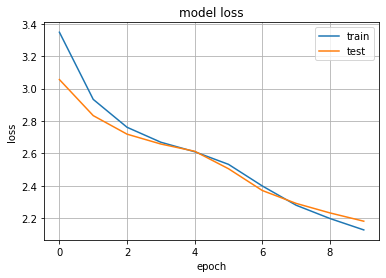

In [ ]:
plt.plot(his.history['loss'])  
plt.plot(his.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.grid()  
plt.legend(['train', 'test'])  
plt.show()

In [ ]:
eng_word = y_token.word_index
new_dict = dict([(value, key) for key, value in eng_word.items()])
new_dict[0] = 'start'

In [ ]:
model = attention_dot_model
def predict_dot_model(input_sentence):
# A. Given input sentence, convert the sentence into integers using tokenizer used earlier
#here we also check the we have the start and end token in sentences
#then we convert out input into to token and do a padding
  input = input_sentence
  if input.split(' ')[0] != '<start>' and input.split(' ')[-1] != '<end>':
    input = '<start>'+ ' ' + input + ' ' + '<end>'
  else:
    input = str(input)
  input = ita_token.texts_to_sequences([str(input)])
  input = pad_sequences(input, padding= 'post',maxlen= 8)

#as we know we have a two layer 1 ==> encoder 2 ==> decoder
#so first is encoder we give the input as input sec and ini_state

  enc_ini_states = model.layers[0].initialize_states(1)
  enc_out, enc_h_state, enc_c_state = model.layers[0](input, enc_ini_states)

  dec_h_state = enc_h_state
  dec_c_state = enc_c_state


#output of the encoder is a input as decoder
# first word input of decoder is start token 
# then 2nd input of decoder is predecting word by model

  decoder_initial_input = np.zeros((1,1))
  decoder_initial_input[0,0] = eng_token.word_index['<start>']

#here we store the word weigth , word and predicted word here predicted word means word token and word means word token corresponding word
  predict_word = []
  word = []
  all_weight = []
  for i in range(8):

    predict , dec_h_state, dec_c_state, att_weight, con_vector =  model.layers[1].One_Step_Decoder(decoder_initial_input, enc_out, dec_h_state, dec_c_state)

    # we use 3rd layer and we get the max proba word as out put and the this word is next input of the decoder 
    english_predict = np.argmax((predict).numpy().ravel())
    predict_word.append(english_predict)
    decoder_initial_input[0,0] = english_predict
    #replacing the next decoder initial states with current decoder output 
    #decoder_initial_state = [dec_h_state, dec_c_state]
    word.append(new_dict[english_predict])
    all_weight.append(att_weight.numpy().ravel())

    weight = np.array(all_weight)

    if new_dict[english_predict] == '<end>':
      break 
  return ' '.join(word) , weight #return the weight and predicted word

In [ ]:
predict_dot_model('i love komal and')[0]

'you posted <end>'

In [ ]:
data_sam = data.sample(20)
for i in range(20):
  print('Input  ==>' , data_sam.enc_inp.iloc[i])
  print('Output ==>' , data_sam.our.iloc[i])
  print('Predict ==>', predict_dot_model(data_sam.enc_inp.iloc[i])[0])
  print(50 * '==')

Input  ==> <start> here are a few to look <end>
Output ==> at <end>
Predict ==> to you <end>
Input  ==> <start> glad to discuss the actuals <end>
Output ==> have been verified <end>
Predict ==> to you have a chance <end>
Input  ==> <start> he said that they <end>
Output ==> were in no hurry to execute trades <end>
Predict ==> are not <end>
Input  ==> <start> hope all is well and <end>
Output ==> as always thanks for your help <end>
Predict ==> you <end>
Input  ==> <start> thanks for your help take a <end>
Output ==> look at this proposal <end>
Predict ==> call me <end>
Input  ==> <start> please see the attached alex will take care of this tonight let me know what you need <end>
Output ==> to do <end>
Predict ==> to discuss <end>
Input  ==> <start> you are doing it <end>
Output ==> again <end>
Predict ==> will be a good weekend <end>
Input  ==> <start> institutional impediments and traders incomplete understanding of the markets however could <end>
Output ==> have delayed or prevented p

### 10.1.1 BLUE score after 10 epoch

In [ ]:
data_sam = data.sample(1000)
import nltk.translate.bleu_score as bleu
bleu_score = []
for i in range(1000):
  reference  = data_sam.our.iloc[i] 
  translation = predict_dot_model(data_sam.enc_inp.iloc[i])[0]
  bleu_score.append(bleu.sentence_bleu([reference.split(),], translation.split()))
print('Bleu Score is ==> ', np.mean(bleu_score))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Bleu Score is ==>  0.5098406574674417


In [ ]:
joblib.dump(his.history,'history1')

['history1']

In [ ]:
#Save weights
attention_dot_model.save_weights('best_model1.h5')

In [ ]:
#Load weights
attention_dot_model.load_weights('best_model1.h5')

In [ ]:
his2 = tf.keras.callbacks.History()
callbacks = [tf.keras.callbacks.TensorBoard(log_dir='logs/model3') , his2]
# #compiling the model
# attention_dot_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = loss_function)
attention_dot_model.fit([x_train_enc , x_train_dec], y_train, steps_per_epoch=450,epochs = 20, validation_data = ([x_test_enc,x_test_dec], y_test), validation_steps = 222 , callbacks = callbacks)

Epoch 1/20
450/450 [==============================] - 47s 104ms/step - loss: 2.0626 - val_loss: 2.1374
Epoch 2/20
450/450 [==============================] - 47s 104ms/step - loss: 2.0022 - val_loss: 2.0958
Epoch 3/20
450/450 [==============================] - 44s 97ms/step - loss: 1.9458 - val_loss: 2.0618
Epoch 4/20
450/450 [==============================] - 43s 96ms/step - loss: 1.8925 - val_loss: 2.0265
Epoch 5/20
450/450 [==============================] - 47s 104ms/step - loss: 1.8426 - val_loss: 1.9990
Epoch 6/20
450/450 [==============================] - 44s 97ms/step - loss: 1.7952 - val_loss: 1.9691
Epoch 7/20
450/450 [==============================] - 47s 104ms/step - loss: 1.7498 - val_loss: 1.9475
Epoch 8/20
450/450 [==============================] - 43s 97ms/step - loss: 1.7067 - val_loss: 1.9203
Epoch 9/20
450/450 [==============================] - 43s 96ms/step - loss: 1.6657 - val_loss: 1.9030
Epoch 10/20
450/450 [==============================] - 43s 96ms/step - loss: 1

In [ ]:
model = attention_dot_model
def predict_dot_model(input_sentence):
# A. Given input sentence, convert the sentence into integers using tokenizer used earlier
#here we also check the we have the start and end token in sentences
#then we convert out input into to token and do a padding
  input = input_sentence
  if input.split(' ')[0] != '<start>' and input.split(' ')[-1] != '<end>':
    input = '<start>'+ ' ' + input + ' ' + '<end>'
  else:
    input = str(input)
  input = ita_token.texts_to_sequences([str(input)])
  input = pad_sequences(input, padding= 'post',maxlen= 8)

#as we know we have a two layer 1 ==> encoder 2 ==> decoder
#so first is encoder we give the input as input sec and ini_state

  enc_ini_states = model.layers[0].initialize_states(1)
  enc_out, enc_h_state, enc_c_state = model.layers[0](input, enc_ini_states)

  dec_h_state = enc_h_state
  dec_c_state = enc_c_state


#output of the encoder is a input as decoder
# first word input of decoder is start token 
# then 2nd input of decoder is predecting word by model

  decoder_initial_input = np.zeros((1,1))
  decoder_initial_input[0,0] = eng_token.word_index['<start>']

#here we store the word weigth , word and predicted word here predicted word means word token and word means word token corresponding word
  predict_word = []
  word = []
  all_weight = []
  for i in range(8):

    predict , dec_h_state, dec_c_state, att_weight, con_vector =  model.layers[1].One_Step_Decoder(decoder_initial_input, enc_out, dec_h_state, dec_c_state)

    # we use 3rd layer and we get the max proba word as out put and the this word is next input of the decoder 
    english_predict = np.argmax((predict).numpy().ravel())
    predict_word.append(english_predict)
    decoder_initial_input[0,0] = english_predict
    #replacing the next decoder initial states with current decoder output 
    #decoder_initial_state = [dec_h_state, dec_c_state]
    word.append(new_dict[english_predict])
    all_weight.append(att_weight.numpy().ravel())

    weight = np.array(all_weight)

    if new_dict[english_predict] == '<end>':
      break 
  return ' '.join(word) , weight #return the weight and predicted word

In [ ]:
predict_dot_model('i love you band')[0]

'you will let you know <end>'

In [ ]:
data_sam = data.sample(20)
for i in range(20):
  print('Input  ==>' , data_sam.enc_inp.iloc[i])
  print('Output ==>' , data_sam.our.iloc[i])
  print('Predict ==>', predict_dot_model(data_sam.enc_inp.iloc[i])[0])
  print(50 * '==')

Input  ==> <start> i would love to see you any review use distribution or disclosure by others is <end>
Output ==> strictly prohibited <end>
Predict ==> strictly prohibited <end>
Input  ==> <start> let me know what you think <end>
Output ==> talk to you soon <end>
Predict ==> the way to go <end>
Input  ==> <start> i attach notes from our conference call today sarah feel free to <end>
Output ==> put these notes on the web site <end>
Predict ==> the meeting <end>
Input  ==> <start> two teams can be allocated for each the source code and build process are sufficient to allow for running almost <end>
Output ==> immediately with its own staff <end>
Predict ==> on the program for a conference rooms for
Input  ==> <start> you know it is a good party when you make the news you should <end>
Output ==> be hearing from him shortly <end>
Predict ==> be <end>
Input  ==> <start> if you have questions on this or anything else <end>
Output ==> please feel free to contact me <end>
Predict ==> is greatl

### 10.1.2 BLUE score after 30 epoch

In [ ]:
data_sam = data.sample(1000)
import nltk.translate.bleu_score as bleu
bleu_score = []
for i in range(1000):
  reference  = data_sam.our.iloc[i] 
  translation = predict_dot_model(data_sam.enc_inp.iloc[i])[0]
  bleu_score.append(bleu.sentence_bleu([reference.split(),], translation.split()))
print('Bleu Score is ==> ', np.mean(bleu_score))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Bleu Score is ==>  0.5011863994763639


In [ ]:
joblib.dump(his2.history,'history2')

['history2']

In [ ]:
h1 = joblib.load('history1')
h2 = joblib.load('history2')
loss = h1['loss']+h2['loss']
val_loss = h1['val_loss']+h2['val_loss']

Text(0.5, 1.0, 'Loss Vs No of epochs')

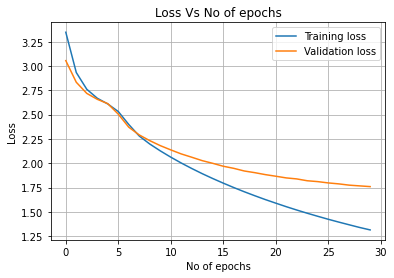

In [ ]:
# loss = his.history['loss']
# val_loss = his.history['val_loss']
plt.plot(loss,label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.grid()
plt.xlabel('No of epochs')
plt.ylabel('Loss')
plt.title('Loss Vs No of epochs')

## 10.2 Attention with General Function

In [ ]:
#defining the model
tf.keras.backend.clear_session()
attention_general_model = encoder_decoder(inp_vocab_size = input_vocab, out_vocab_size = output_vocab,
                                      embedding_size = 300, enc_lstm_units = 256, dec_lstm_units = 256, 
                                      enc_input_length = 31, dec_input_length = 8, score_fun = 'general', 
                                      att_units = 256)
his = tf.keras.callbacks.History()
callbacks = [tf.keras.callbacks.TensorBoard(log_dir='logs/model4_general') , his]
#compiling the model
attention_general_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = loss_function)

In [ ]:
attention_general_model.fit([x_train_enc , x_train_dec], y_train, steps_per_epoch=450,epochs = 20, validation_data = ([x_test_enc,x_test_dec], y_test), validation_steps = 222 , callbacks = callbacks)

Epoch 1/20
450/450 [==============================] - 75s 133ms/step - loss: 3.3461 - val_loss: 3.0379
Epoch 2/20
450/450 [==============================] - 57s 126ms/step - loss: 2.9134 - val_loss: 2.8144
Epoch 3/20
450/450 [==============================] - 56s 124ms/step - loss: 2.7457 - val_loss: 2.7050
Epoch 4/20
450/450 [==============================] - 55s 123ms/step - loss: 2.6540 - val_loss: 2.6438
Epoch 5/20
450/450 [==============================] - 56s 124ms/step - loss: 2.5955 - val_loss: 2.6037
Epoch 6/20
450/450 [==============================] - 57s 127ms/step - loss: 2.5478 - val_loss: 2.5608
Epoch 7/20
450/450 [==============================] - 56s 124ms/step - loss: 2.5024 - val_loss: 2.5277
Epoch 8/20
450/450 [==============================] - 57s 127ms/step - loss: 2.4665 - val_loss: 2.5002
Epoch 9/20
450/450 [==============================] - 56s 124ms/step - loss: 2.4324 - val_loss: 2.4723
Epoch 10/20
450/450 [==============================] - 56s 124ms/step - l

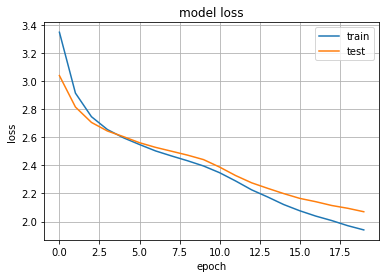

In [ ]:
plt.plot(his.history['loss'])  
plt.plot(his.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.grid()  
plt.legend(['train', 'test'])  
plt.show()

In [ ]:
model = attention_general_model
def predict_general_model(input_sentence):
# A. Given input sentence, convert the sentence into integers using tokenizer used earlier
#here we also check the we have the start and end token in sentences
#then we convert out input into to token and do a padding
  input = input_sentence
  if input.split(' ')[0] != '<start>' and input.split(' ')[-1] != '<end>':
    input = '<start>'+ ' ' + input + ' ' + '<end>'
  else:
    input = str(input)
  input = ita_token.texts_to_sequences([str(input)])
  input = pad_sequences(input, padding= 'post',maxlen= 8)

#as we know we have a three layer 1 ==> encoder 2 ==> decoder 3 ==> dense
#so first is encoder we give the input as input sec and ini_state

  enc_ini_states = model.layers[0].initialize_states(1)
  enc_out, enc_h_state, enc_c_state = model.layers[0](input, enc_ini_states)

  dec_h_state = enc_h_state
  dec_c_state = enc_c_state


#output of the encoder is a input as decoder
# first word input of decoder is start token 
# then 2nd input of decoder is predecting word by model

  decoder_initial_input = np.zeros((1,1))
  decoder_initial_input[0,0] = eng_token.word_index['<start>']


  predict_word = []
  word = []
  all_weight = []
  for i in range(8):

    predict , dec_h_state, dec_c_state, att_weight, con_vector =  model.layers[1].One_Step_Decoder(decoder_initial_input, enc_out, dec_h_state, dec_c_state)

    # we use 3rd layer and we get the max proba word as out put and the this word is next input of the decoder 
    english_predict = np.argmax((predict).numpy().ravel())
    predict_word.append(english_predict)
    decoder_initial_input[0,0] = english_predict
    #replacing the next decoder initial states with current decoder output 
    #decoder_initial_state = [dec_h_state, dec_c_state]
    word.append(new_dict[english_predict])
    all_weight.append(att_weight.numpy().ravel())

    weight = np.array(all_weight)

    if new_dict[english_predict] == '<end>':
      break
  return ' '.join(word) , weight
predict_general_model('<start> let me know if  <end>')[0]

'you have any questions <end>'

In [ ]:
data_sam = data.sample(20)
for i in range(20):
  print('Input  ==>' , data_sam.enc_inp.iloc[i])
  print('Output ==>' , data_sam.our.iloc[i])
  print('Predict ==>', predict_general_model(data_sam.enc_inp.iloc[i])[0])
  print(50 * '==')

Input  ==> <start> you are the man see most recent email thanks a million i owe you one this <end>
Output ==> one was really a hot potato <end>
Predict ==> is prohibited scares <end>
Input  ==> <start> brent is waiting for the arrival of his cabinet installer who is running late he will be in as soon as he <end>
Output ==> can <end>
Predict ==> is not be provided <end>
Input  ==> <start> give me a shout i did not think it would be that soon talk to you soon any review use distribution or <end>
Output ==> disclosure by others is strictly prohibited <end>
Predict ==> if disucss propane butane and discuss <end>
Input  ==> <start> you can ignore the other file as it is not applicable to engineering thanks and call if this is <end>
Output ==> not clear <end>
Predict ==> legal scares properties mentioning lukemia properties mentioning lukemia
Input  ==> <start> but let me know what you want me to look for in the remaining <end>
Output ==> deals <end>
Predict ==> intensive suffered cream elig

In [ ]:
data_sam = data.sample(1000)
import nltk.translate.bleu_score as bleu
bleu_score = []
for i in range(1000):
  reference  = data_sam.our.iloc[i] 
  translation = predict_general_model(data_sam.enc_inp.iloc[i])[0]
  bleu_score.append(bleu.sentence_bleu([reference.split(),], translation.split()))
print('Bleu Score is ==> ', np.mean(bleu_score))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Bleu Score is ==>  0.4048202788918177


## 10.3 Attention with Concat Function

In [ ]:
#defining the model
tf.keras.backend.clear_session()
attention_concat_model = encoder_decoder(inp_vocab_size = input_vocab, out_vocab_size = output_vocab,
                                      embedding_size = 256, enc_lstm_units = 256, dec_lstm_units = 256, 
                                      enc_input_length = 31, dec_input_length = 8, score_fun = 'concat', 
                                      att_units = 256)
his = tf.keras.callbacks.History()
callbacks = [tf.keras.callbacks.TensorBoard(log_dir='logs/model2') , his]
#compiling the model
attention_concat_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = loss_function)

In [ ]:
attention_concat_model.fit([x_train_enc , x_train_dec], y_train, steps_per_epoch=450,epochs = 20, validation_data = ([x_test_enc,x_test_dec], y_test), validation_steps = 222 , callbacks = callbacks)

Epoch 1/20
450/450 [==============================] - 78s 137ms/step - loss: 3.3601 - val_loss: 3.0586
Epoch 2/20
450/450 [==============================] - 59s 132ms/step - loss: 2.9137 - val_loss: 2.7640
Epoch 3/20
450/450 [==============================] - 59s 131ms/step - loss: 2.6411 - val_loss: 2.5452
Epoch 4/20
450/450 [==============================] - 59s 130ms/step - loss: 2.4388 - val_loss: 2.3878
Epoch 5/20
450/450 [==============================] - 59s 131ms/step - loss: 2.2881 - val_loss: 2.2754
Epoch 6/20
450/450 [==============================] - 59s 131ms/step - loss: 2.1717 - val_loss: 2.1896
Epoch 7/20
450/450 [==============================] - 59s 131ms/step - loss: 2.0713 - val_loss: 2.1133
Epoch 8/20
450/450 [==============================] - 59s 131ms/step - loss: 1.9824 - val_loss: 2.0512
Epoch 9/20
450/450 [==============================] - 59s 130ms/step - loss: 1.9018 - val_loss: 1.9970
Epoch 10/20
450/450 [==============================] - 59s 131ms/step - l

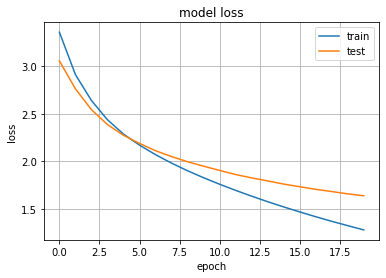

In [ ]:
plt.plot(his.history['loss'])  
plt.plot(his.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.grid()  
plt.legend(['train', 'test'])  
plt.show()

In [ ]:
model = attention_concat_model
def predict_concat_model(input_sentence):
# A. Given input sentence, convert the sentence into integers using tokenizer used earlier
#here we also check the we have the start and end token in sentences
#then we convert out input into to token and do a padding
  input = input_sentence
  if input.split(' ')[0] != '<start>' and input.split(' ')[-1] != '<end>':
    input = '<start>'+ ' ' + input + ' ' + '<end>'
  else:
    input = str(input)
  input = ita_token.texts_to_sequences([str(input)])
  input = pad_sequences(input, padding= 'post',maxlen= 8)

#as we know we have a three layer 1 ==> encoder 2 ==> decoder 3 ==> dense
#so first is encoder we give the input as input sec and ini_state

  enc_ini_states = model.layers[0].initialize_states(1)
  enc_out, enc_h_state, enc_c_state = model.layers[0](input, enc_ini_states)

  dec_h_state = enc_h_state
  dec_c_state = enc_c_state


#output of the encoder is a input as decoder
# first word input of decoder is start token 
# then 2nd input of decoder is predecting word by model

  decoder_initial_input = np.zeros((1,1))
  decoder_initial_input[0,0] = eng_token.word_index['<start>']


  predict_word = []
  word = []
  all_weight = []
  for i in range(8):

    predict , dec_h_state, dec_c_state, att_weight, con_vector =  model.layers[1].One_Step_Decoder(decoder_initial_input, enc_out, dec_h_state, dec_c_state)

    # we use 3rd layer and we get the max proba word as out put and the this word is next input of the decoder 
    english_predict = np.argmax((predict).numpy().ravel())
    predict_word.append(english_predict)
    decoder_initial_input[0,0] = english_predict
    #replacing the next decoder initial states with current decoder output 
    #decoder_initial_state = [dec_h_state, dec_c_state]
    word.append(new_dict[english_predict])
    all_weight.append(att_weight.numpy().ravel())

    weight = np.array(all_weight)

    if new_dict[english_predict] == '<end>':
      break
  return ' '.join(word) , weight
predict_concat_model('<start> we are making a number of <end>')[0]

'few oour reminders <end>'

In [ ]:
data_sam = data.sample(20)
for i in range(20):
  print('Input  ==>' , data_sam.enc_inp.iloc[i])
  print('Output ==>' , data_sam.our.iloc[i])
  print('Predict ==>', predict_concat_model(data_sam.enc_inp.iloc[i])[0])
  print(50 * '==')

Input  ==> <start> let me know what else you will need to prepare the statistical analysis the numbers include highs and lows let me know your ideas on how to address <end>
Output ==> this in the quote <end>
Predict ==> your help <end>
Input  ==> <start> thank you for your suggestions during our phone conversation the other day as of this afternoon the website is up and running if you have <end>
Output ==> questions please contact me <end>
Predict ==> questions please let me know <end>
Input  ==> <start> this displays the severity of the <end>
Output ==> supply issues <end>
Predict ==> crock <end>
Input  ==> <start> this is to have unhindered <end>
Output ==> governor response throughout the system <end>
Predict ==> email <end>
Input  ==> <start> let me know if you <end>
Output ==> have concerns <end>
Predict ==> comments <end>
Input  ==> <start> please find attached execution copies of the above captioned documents thank you for <end>
Output ==> your attention to these matters <end>
P

In [ ]:
data_sam = data.sample(1000)
import nltk.translate.bleu_score as bleu
bleu_score = []
for i in range(1000):
  reference  = data_sam.our.iloc[i] 
  translation = predict_concat_model(data_sam.enc_inp.iloc[i])[0]
  bleu_score.append(bleu.sentence_bleu([reference.split(),], translation.split()))
print('Bleu Score is ==> ', np.mean(bleu_score))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Bleu Score is ==>  0.4755912718751114


In [2]:
from prettytable import PrettyTable

# Specify the Column Names while initializing the Table
myTable = PrettyTable(["Model Name", "BLUE Score"])

# Add rows
myTable.add_row(["Simple LSTM", "0.20"])
myTable.add_row(["Encoder Decoder" , '0.70'])
myTable.add_row(["Encoder Decoder Attention With Dot Function", '0.50'])
myTable.add_row(["Encoder Decoder Attention With General Function", '0.40'])
myTable.add_row(["Encoder Decoder Attention With Concat Function", '0.47'])


print(myTable)

+-------------------------------------------------+------------+
|                    Model Name                   | BLUE Score |
+-------------------------------------------------+------------+
|                   Simple LSTM                   |    0.20    |
|                 Encoder Decoder                 |    0.70    |
|   Encoder Decoder Attention With Dot Function   |    0.50    |
| Encoder Decoder Attention With General Function |    0.40    |
|  Encoder Decoder Attention With Concat Function |    0.47    |
+-------------------------------------------------+------------+
